## Example 6 – Replication of Habit Model in Wachter (2006) in Continuous Time
### Time-Varying Surplus Consumption Ratio
This example replicates some main results from Wachter (2006) as adapted to continuous time. The results replicated are the yields of real bonds and the price-consumption ratio. The state variable in the model is the surplus consumption ratio, which is part of the utility function. It evolves according to:

$$
\mathrm{d}s_t=-\log\phi(\bar{s}-s_t)\mathrm{d}t+\lambda(s_t)\sigma_{c}\mathrm{d}W_{t}
$$

The modified state variable and short rate for the calculation of the price-consumption ratio evolves according to:

$$
\mathrm{d}\tilde{s}_t=\Big(-\log\phi(\bar{s}-\gamma\tilde{s}_t)+\lambda(\tilde{s}_t)\sigma_{c}+\Big)\mathrm{d}t+\lambda(\tilde{s}_t)\sigma_c\mathrm{d}W_{t}
$$
$$
\tilde{r}(\tilde{s}_t)=\rho+\gamma\log(\phi)\tilde{s}_t+\gamma \mu_c-\frac{\gamma^2\sigma_c^2}{2}\big(1+\lambda(s)\big)^2-\mu_c-\sigma_c^2\lambda(\tilde{s}_t)
$$

In order to get the price of the consumption strip, the following stochastic integral needs to be simulated:

$$
\mathrm{d}\mathcal{I}_2 = \tilde{r}(\tilde{x}_t)\mathrm{d}t
$$

##### Import the packages

In [1]:
import SDFPricing as sdf
import StochasticDiffEq as sde # this is needed in order to specify the algorithm

#### Define the parameters

In [2]:
#? parameters from Campbell, Cochrane (1999) (also Wachter (2005) Solving Models with External Habit)
cs = (
    phi = 0.87, # mean reversion
    gamma = 2.0, # risk aversion
    b = 0.0, 
    xbar = 0.0, # long-run mean
    rho = -log(0.895), # time preference parameter
    muc0 = 0.0189, # consumption drift
    sigmac = 0.015, # consumption diffusion
    rhocx = 1.0, # correlation between consumption and state variable
    sigmaD = 0.015, # dividend diffusion ###- case of consumption perpetuity
    muD = 0.0189, # dividend drift ###- case of consumption perpetuity
    rhoxD = 1.0, # correlation between dividends and state variable ###- case of consumption perpetuity
    rhocD = 1.0 # correlation between dividends and consumption ###- case of consumption perpetuity
);

#### Drift and Diffusion of the processes
I also include the unmodified process which will correspond to "risk-neutral pricing". By comparing normal pricing with risk-neutral pricing it is possible to compute excess returns.

In [3]:
###- now consumption diffusion is a non-linear function of the state, 
###- given that it needs to be positive.
###- I use this function because the simple exponential can get too high for some samples.
Sbar = cs.sigmac*(cs.gamma/(-log(cs.phi)-cs.b/cs.gamma))^(1/2);
# Sbar = cs.sigmac*(cs.gamma/(1-cs.phi-cs.b/cs.gamma))^(1/2);
lambda(x) = x<(1-Sbar^2)/2 ? (1-2*x)^(1/2)/Sbar-1 : 0;
sigmac(x,c) = c.sigmac;
sigmac(x) = sigmac(x,cs); 
sigmaL(x) = -cs.gamma*sigmac(x)*(1+lambda(x)) 
# sigmaD(x,c) = defineSomeFunctionOf(x,c); #- general dividend diffusion
sigmaD(x,c) = sigmac(x,c); #- case of consumption perpetuity
sigma(x,c) = sigmac(x)*lambda(x); # diffusion of modified state
mu00(x,c) = -log(c.phi)*(c.xbar-x); # drift of unmodified state
mu0(x,c) = mu00(x,c)+c.rhocx*sigma(x,c)*sigmaL(x); # drift of modified state for yield
# drift of modified state for price consumption ratio
mu(x,c) = mu0(x,c)+c.rhoxD*sigma(x,c)*sigmaD(x,c); 

#### Short-term rate function

In [4]:
r(x,c) = c.rho+c.gamma*log(c.phi)*x+c.gamma*c.muc0-sigmaL(x)^2/2;
r(x) = r(x,cs);
muD(x) = cs.muD; # perpetuity with constant dividend drift
rmod(x,c) = r(x,c)-muD(x)-c.rhocD*sigmaD(x,c)*sigmaL(x);
rmod(x) = rmod(x,cs);

#### Define setup consistent with SDE solution in Julia

In [5]:
function drift(du,u,p,t,c)
    du[1] = mu(u[1],c)
    du[2] = rmod(u[1],c)
end
drift(du,u,p,t) = drift(du,u,p,t,cs);
function diffusion(du,u,p,t,c)
    du[1] = sigma(u[1],c)
    du[2] = 0.0
end
diffusion(du,u,p,t) = diffusion(du,u,p,t,cs);

#### Define the Problem and SolutionSettings variables

In [6]:
prob = sdf.Problem(drift=drift,diffusion=diffusion,numNoiseVariables=1,outVariables=[2],
terminalFunction=(ik, x, y, z) -> exp(-x));
xRange = -2.5:0.05:0.5;
tRange = 0.0:5.:120.0;

sett = sdf.SolutionSettings(xRanges=[xRange,], initialValues=[[x,0.0] for x in xRange], 
algorithm=sde.LambaEM(), pathsPerInitialValue=1000, tRange=tRange,dt=0.005);
# add the settings in order to compmute price-dividend ration of the continuous payoff security
sett2 = sdf.SolutionSettings(sett; continuousPayoffVars=[2]);

#### Solve Problem and Define Yield

In [7]:
((singlePayoff),continuousPayoff) = sdf.solve(prob, sett2);
yld1(t,x) = -log(singlePayoff[1](t,x))/(t);

#### Plot the price-consumption ratio

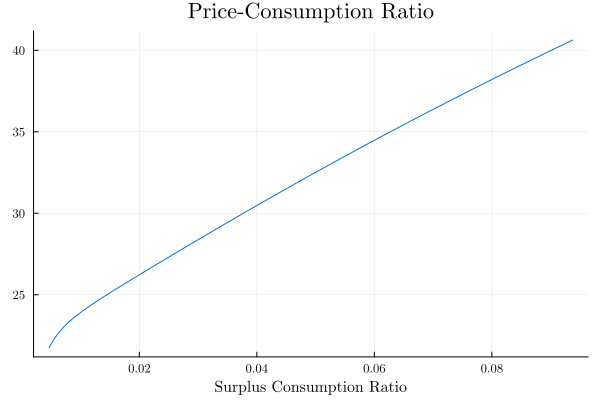

In [8]:
import Plots as plt
plt.default(titlefont= (14,"Computer Modern"),legendfont=(8,"Computer Modern"),
    tickfont=(8,"Computer Modern"),guidefont=(10,"Computer Modern"))
plt.plot(Sbar.*exp.(xRange), continuousPayoff[1](xRange), legend=false,
    title="Price-Consumption Ratio",color="#0075d6", xlabel="Surplus Consumption Ratio")

Here the result is significantly different compared to the original paper. This shows that the result can vary significantly based on the numerical methods used. 
See Wachter (2005) Solving Models with External Habit for a discussion of the numerical issues involved.
With further development of the package I am planning to make these issues more transparent and these problems better manageable with the appropriate methods.